# Augmenting Medical Images: Chest X-ray 14 dataset

In this notebook, we  will show how to easily use SOLT for medical images. Here, we will take Chest X-ray 14 dataset for our experiments and will implement a pipeline for radiological finding localization.

Please, download the archive  **images/images_001.tar.gz** from the NIH website https://nihcc.app.box.com/v/ChestXray-NIHCC/ and unpack it into **Data/CXR/images**. Please, also download the BBox annotations **BBox_List_2017.csv** into **Data/CXR/BBox_List_2017.csv** .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
import glob
import cv2

import solt.transforms as slt
import solt.data as sld
import solt.core as slc

np.random.seed(1234)

## Loading the metadata and looking for images, which have several bboxes

In [2]:
metadata = pd.read_csv('Data/CXR/BBox_List_2017.csv')
metadata = metadata[metadata.columns[:-3]]
metadata['x'] = metadata['Bbox [x'].copy()
metadata['h'] = metadata['h]'].copy()
metadata['finding'] = metadata['Finding Label'].copy()

metadata.drop(['Bbox [x'], axis=1, inplace=True)
metadata.drop(['h]'], axis=1, inplace=True)
metadata.drop(['Finding Label'], axis=1, inplace=True)

In [3]:
metadata.head()

Image Index           y           w           x           h  \
0  00013118_008.png  547.019217   86.779661  225.084746   79.186441   
1  00014716_007.png  131.543498  185.491525  686.101695  313.491525   
2  00029817_009.png  317.053115  155.118644  221.830508  216.949153   
3  00014687_001.png  494.951420  141.016949  726.237288   55.322034   
4  00017877_001.png  569.780787  200.677966  660.067797   78.101695   

       finding  
0  Atelectasis  
1  Atelectasis  
2  Atelectasis  
3  Atelectasis  
4  Atelectasis

In [4]:
img_list = glob.glob(os.path.join('Data', 'CXR', 'images', '*.png'))
imgs_set = set(map(lambda x: x.split('/')[-1], img_list))
metadata['img_present'] = metadata.apply(lambda x: x[0] in imgs_set, 1)
metadata = metadata[metadata.img_present == True]

In [5]:
for img_name, df in metadata.groupby('Image Index'):
    if df.shape[0] > 1:
        break

In [6]:
df

Image Index           y           w           x           h  \
202  00000732_005.png  464.000000  412.203390  427.932203  344.949153   
918  00000732_005.png  110.686823  172.942222  613.831111  103.537778   

          finding  img_present  
202  Cardiomegaly         True  
918  Pneumothorax         True

## Visualizing the image

In [7]:
img = cv2.imread(os.path.join('Data', 'CXR', 'images', img_name))

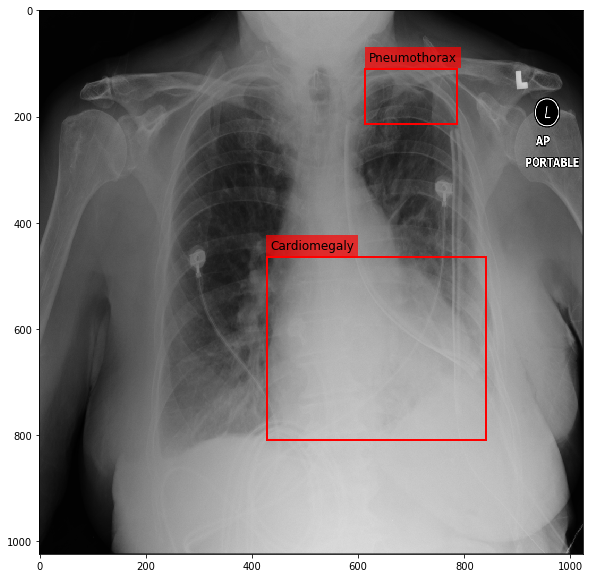

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.imshow(img, cmap=plt.cm.Greys_r)

text_bbox = dict(facecolor='red', alpha=0.7, lw=0)
for _, entry in df.iterrows():
    ax.add_patch(Rectangle((entry.x, entry.y), entry.w, entry.h, fill=False, color='r', lw=2))
    ax.text(entry.x+6, entry.y-15, entry.finding,fontsize=12, bbox=text_bbox)
plt.show()

## Creating a data container with the image, keypoints and the labels

We will encode Cardiomegaly as 0 and Pneumothorax as 1. In our case it is the first and the second rows respectively:

In [9]:
df

Image Index           y           w           x           h  \
202  00000732_005.png  464.000000  412.203390  427.932203  344.949153   
918  00000732_005.png  110.686823  172.942222  613.831111  103.537778   

          finding  img_present  
202  Cardiomegaly         True  
918  Pneumothorax         True

In SOLT, we decided to not implement separate class of augmentations for bounding boxes. Instead, we implemented all teh transformations for keypoints and thus we can just convert the bboxes into 4 keypoints:

In [10]:
pts = df[['x', 'y', 'w', 'h']].values
p1 = pts[:, :2].copy() # left top

p2 = pts[:, :2].copy()  # right top
p2[:, 0] += pts[:, 2]

p3 = pts[:, :2].copy()  # right bottom
p3[:, 0] +=  pts[:, 2]
p3[:, 1] +=  pts[:, 3]

p4 = pts[:, :2].copy()  # left bottom
p4[:, 1] +=  pts[:, 3]


cardiomegaly_kpts = sld.KeyPoints(np.vstack((p1[0], p2[0], p3[0], p4[0])), img.shape[0], img.shape[1])
pneumothorax_kpts = sld.KeyPoints(np.vstack((p1[1], p2[1], p3[1], p4[1])), img.shape[0], img.shape[1])

In [11]:
cardiomegaly_kpts.data

array([[427.93220339, 464.        ],
       [840.13559322, 464.        ],
       [840.13559322, 808.94915254],
       [427.93220339, 808.94915254]])

Alright, now we were able to store the bbox as keypoints, we can create a data container

In [12]:
dc = sld.DataContainer((img, cardiomegaly_kpts, 0, pneumothorax_kpts, 1), 'IPLPL')

As you can see from the above cell, the DataContainer does not care about the order of the objects in it, thus, we just used the format:

* Image
* Keypoints
* Label
* Keypoints
* Label

Now, let's implement a simple augmentation pipeline.

## Augmentation stream

In [13]:
stream = slc.Stream([
    slt.RandomProjection(
            slc.Stream([
                slt.RandomScale(range_x=(0.8, 1.1), p=1),
                slt.RandomRotate(rotation_range=(-90, 90), p=1),
                slt.RandomShear(range_x=(-0.2, 0.2), range_y=None, p=0.7),
        ]), 
        v_range=(1e-6, 3e-4), p=1),
    # Various cropping and padding tricks
    slt.PadTransform(1000, 'z'),
    slt.CropTransform(1000, crop_mode='c'),
    slt.CropTransform(950, crop_mode='r'),
    slt.PadTransform(1000, 'z'),
    # Intensity augmentations
    slt.ImageGammaCorrection(p=1, gamma_range=(0.5, 3)),
    slc.SelectiveStream([
        slc.SelectiveStream([
            slt.ImageSaltAndPepper(p=1, gain_range=0.01),
            slt.ImageBlur(p=0.5, blur_type='m', k_size=(11,)),
        ]),
        slt.ImageAdditiveGaussianNoise(p=1, gain_range=0.5),
    ]),
])

## Augmenting a Chest X-ray

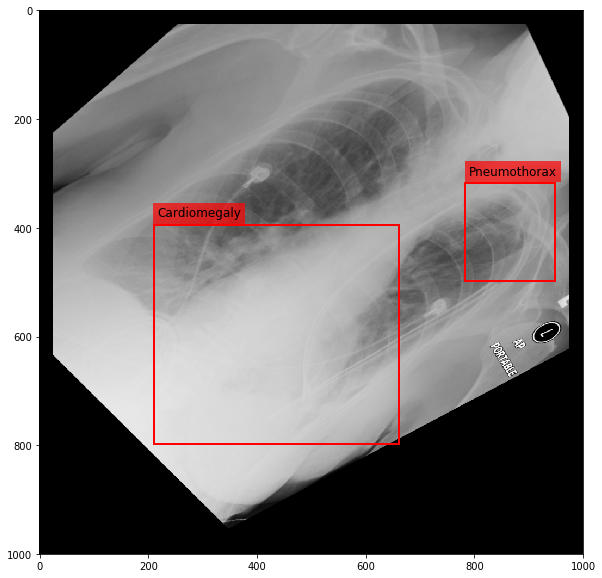

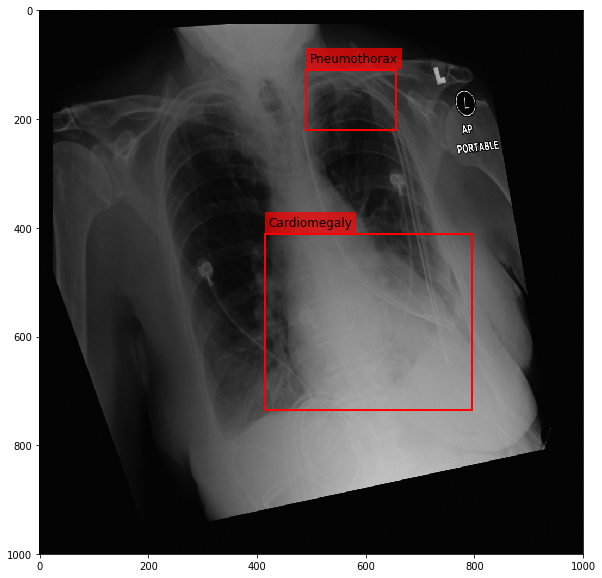

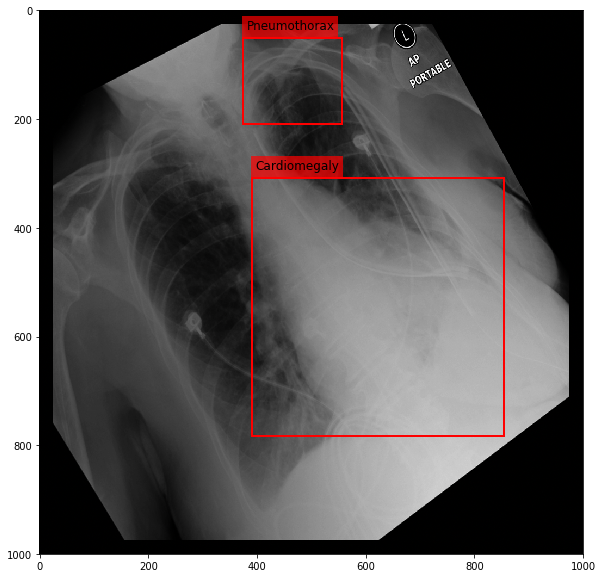

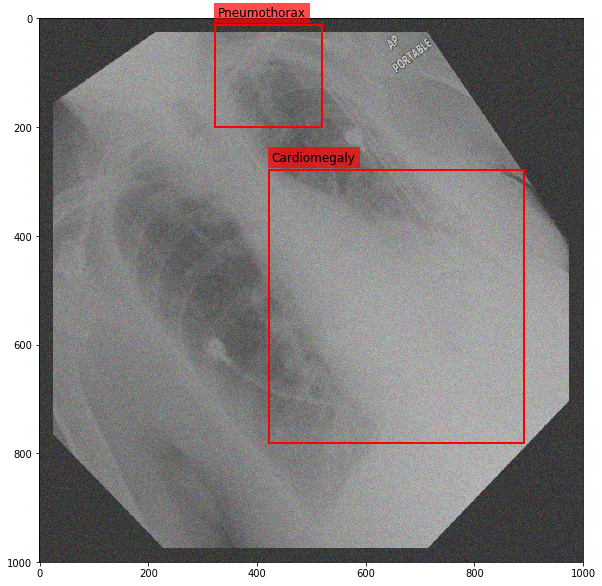

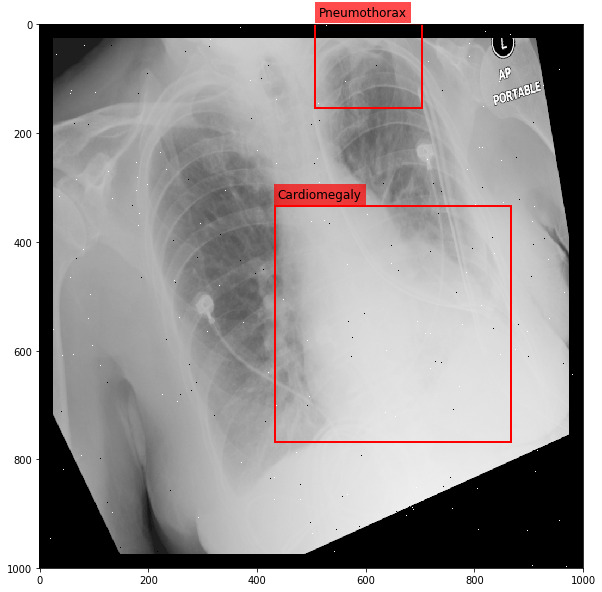

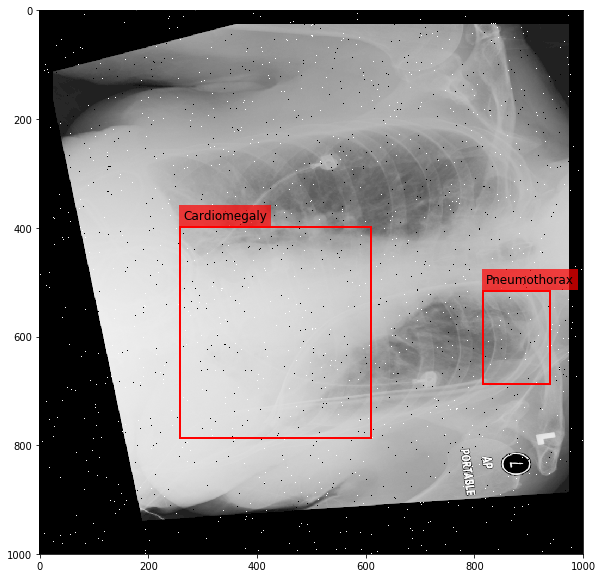

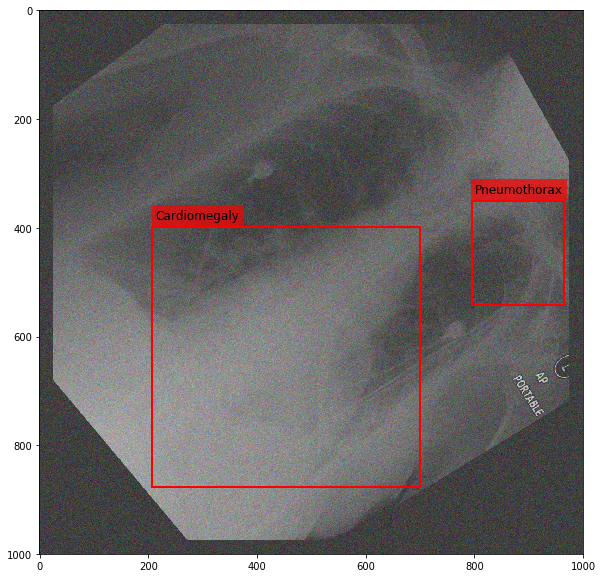

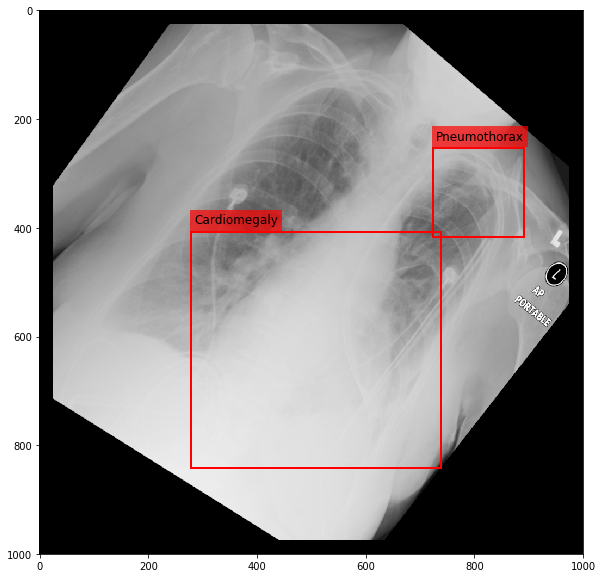

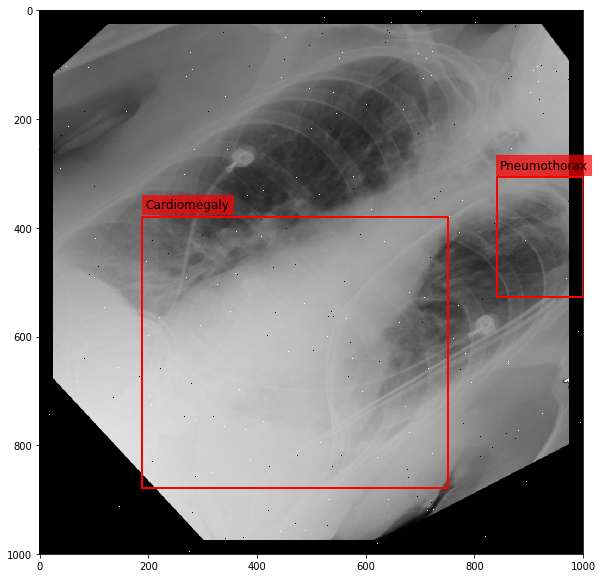

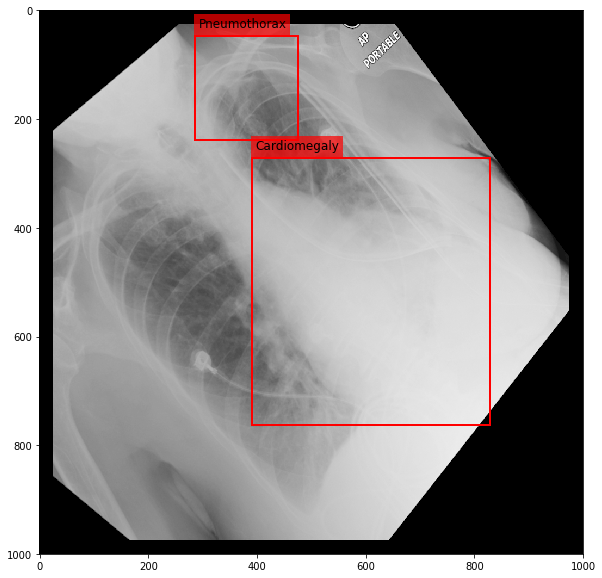

In [14]:
for i in range(10):
    res = stream(dc)
    img_res, kp_c, lbl_c, kp_p, lbl_p = res.data
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_res, cmap=plt.cm.Greys_r)

    for pts, cls in zip([kp_c.data, kp_p.data], ['Cardiomegaly', 'Pneumothorax']):
        text_bbox = dict(facecolor='red', alpha=0.7, lw=0)
        # Let's clip the points so that they will not
        # violate the image borders
        pts[:, 0] = np.clip(pts[:, 0], 0, img_res.shape[1]-1)
        pts[:, 1] = np.clip(pts[:, 1], 0, img_res.shape[0]-1)
        x, y = pts[:, 0].min(), pts[:, 1].min()
        w, h = pts[:, 0].max()-x, pts[:, 1].max()-y
        ax.add_patch(Rectangle((x, y), w, h, fill=False, color='r', lw=2))
        ax.text(x+6, y-15, cls, fontsize=12, bbox=text_bbox)
    plt.show()